# Try to reconfigure OpSim for other cadence

*Evenly distribute and include the galactic plane*

In [6]:
from OpSim import OpSim
from astropy.coordinates import SkyCoord
from astropy import units
import numpy as np

import matplotlib.pyplot as plt

%matplotlib notebook

filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']

In [3]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/minion_1016_sqlite.db' #for the OpSim database   
OpS.getAllOpSimFields()

getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


In [4]:
print(OpS.Nobs[1])

180.0


In [5]:
print(np.max(OpS.Nobs[np.where(OpS.Nobs < 5000)]))

922.0


<IPython.core.display.Javascript object>


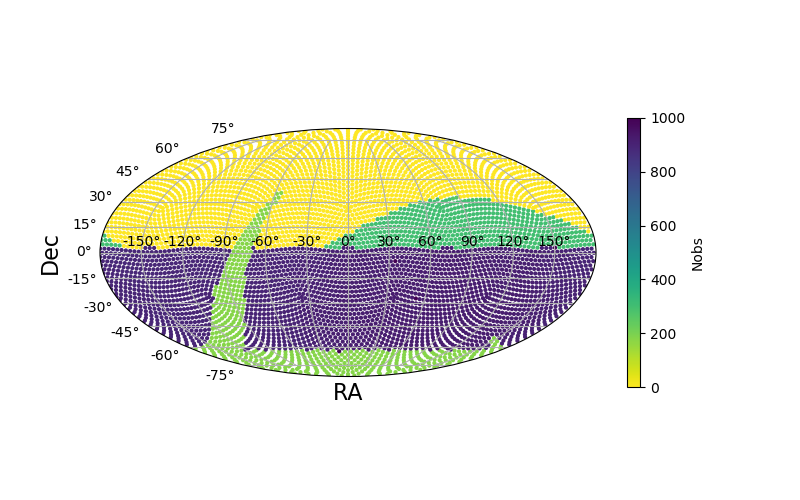

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


In [6]:
coords = SkyCoord(OpS.RA, OpS.Dec, unit=(units.degree, units.degree),frame='icrs')

RAwrap = coords.ra.wrap_at(180.*units.degree).degree
Decwrap = coords.dec.wrap_at(180.*units.degree).degree

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"}, figsize=(8,5))
ax.grid(True)
ax.set_xlabel("RA",fontsize=16)
ax.set_ylabel("Dec",fontsize=16)
mlw = ax.scatter(np.array(RAwrap).ravel()*np.pi/180., 
                 np.array(Decwrap).ravel()*np.pi/180., 
                 c=OpS.Nobs, #probably want this in a given filter, but that takes a long time to gather
                 cmap='viridis_r', s = 4, vmin=0, vmax=1000)
cbar = f.colorbar(mlw, shrink=0.7)
cbar.set_label(r'Nobs')


### Take only the fields that are observed and get their dates

In [7]:
observed = np.where(OpS.Nobs > 0)
primary = np.where(OpS.Nobs > 800)
print(len(observed[0]))
print(len(primary[0]))

3339
2295


*There will be this many observations in each of these fields*

*Neglect the fields with the very large number of obs -- is this a bug or because of overlap and/or a planned revisit?*

In [8]:
Nfields = len(observed[0])
Nobs = OpS.Nobs[observed]

bad = np.where(Nobs > 5000)
good = np.where(Nobs < 5000)
#print(bad, Nobs[bad])
Nobs[bad] = np.max(Nobs[good])
#print(Nobs[bad])

NtotalObs = np.sum(Nobs)
print("Nfields, NtotalObs, NObsPerField = ",Nfields, NtotalObs, NtotalObs/Nfields)

Nfields, NtotalObs, NObsPerField =  3339 2338183.0 700.2644504342618


### Let's try to construct a CDF of the dt inbetween observations

In [9]:
#this takes a long time to run through...
OpSimi = OpS.fieldID[primary].astype("int")
OpS.dt = np.array([{} for i in OpSimi])
OpSimi = OpSimi[0:2] #take only the first two for testing
for i in OpSimi: 
    print(i)
    dt = {}
    OpS.setDates(i, filters)
    for f in filters:
        dt[f] = np.diff(OpS.obsDates[i][f])
    OpS.dt[i] = dt

290
309


In [23]:
i = OpSimi[0]
print(OpS.NobsDates[i])
print(OpS.Nobs)
#print(OpS.dt[i][filters[0]])

{'u_': 30, 'g_': 30, 'r_': 30, 'i_': 30, 'z_': 30, 'y_': 30}
[180. 180. 180. ...   0.   0.   0.]
{'u_': array([  3.1358912 ,   5.11234954, 148.37447917, 148.37939815,
       148.39324074, 148.40395833, 148.40619213, 148.41606481,
       150.29435185, 150.30103009, 150.3028125 , 150.31171296,
       150.31884259, 150.32196759, 150.35503472, 150.35592593,
       150.37777778, 150.38540509, 150.40016204, 150.40732639,
       175.2252662 , 175.22748843, 175.23243056, 175.25075231,
       175.25386574, 205.16060185, 205.16894676, 205.18739583,
       205.38854167, 206.38314815]), 'g_': array([146.30390046, 146.30789352, 146.31236111, 146.31859954,
       146.31993056, 146.32482639, 146.33197917, 146.33375   ,
       146.34353009, 146.34886574, 146.35644676, 146.37295139,
       146.37875   , 146.38634259, 146.39215278, 146.39885417,
       146.40064815, 146.40778935, 146.42121528, 173.37550926,
       173.37865741, 173.40556713, 173.41546296, 173.42039352,
       181.21240741, 181.23200231,

*Construct the CDF.  Ideally we wouldn't bin it, but I think this will be easier to do given that there are about 3000 fields and we'd want to run this in MPI on Quest.*

<IPython.core.display.Javascript object>


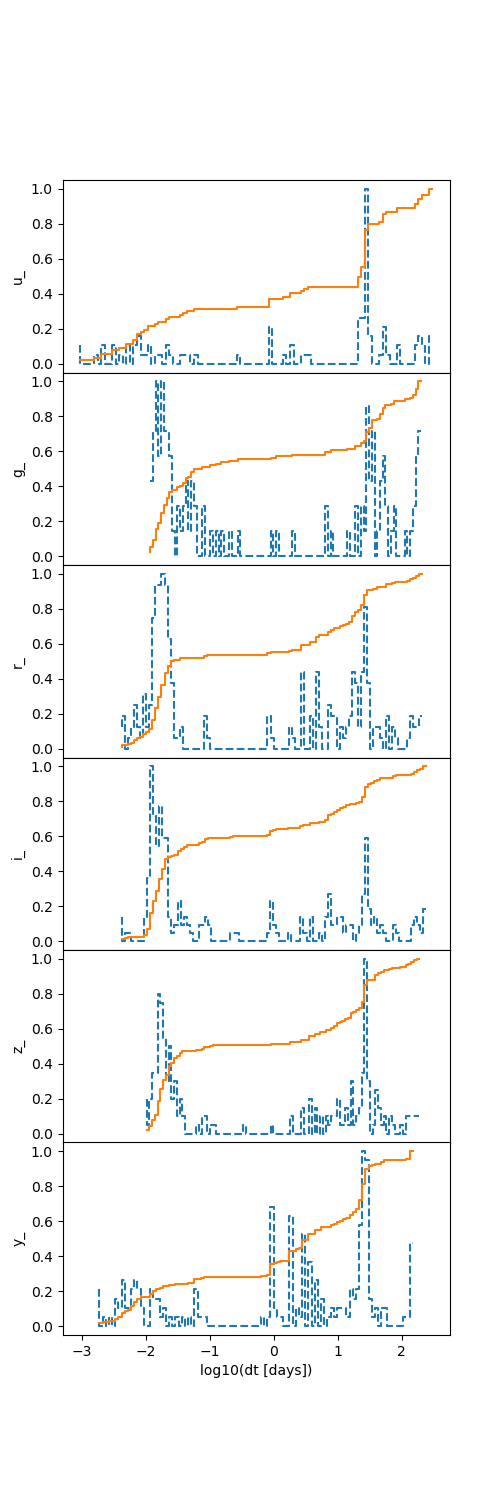

In [36]:
f,ax = plt.subplots(len(filters),1, figsize=(5,15), sharex=True)
Nbins = 100
dist = {}
for a,f in zip(ax, filters):
    pdf = np.zeros(Nbins)
    for i in OpSimi: #sum up all the dt's in that filter across all fields
        p,bin_edges = np.histogram(np.log10(OpS.dt[i][f]), bins=Nbins)
        pdf += p
    bins = bin_edges[:-1] + np.diff(bin_edges)/2.
    cdf = np.cumsum(pdf)
    a.step(bins,pdf/np.max(pdf),linestyle='--')
    a.step(bins,cdf/np.max(cdf))
    a.set_ylabel(f)
    
    dist[f] = {}
    dist[f]['bins']= bins
    dist[f]['cdf']= cdf/np.max(cdf)
    dist[f]['pdf']= pdf/np.max(pdf)
    
ax[-1].set_xlabel('log10(dt [days])')
plt.subplots_adjust(hspace=0)

In [12]:
print(dist[filters[1]])

{'bins': array([-1.92926204, -1.88650934, -1.84375664, -1.80100394, -1.75825124,
       -1.71549855, -1.67274585, -1.62999315, -1.58724045, -1.54448775,
       -1.50173505, -1.45898236, -1.41622966, -1.37347696, -1.33072426,
       -1.28797156, -1.24521886, -1.20246617, -1.15971347, -1.11696077,
       -1.07420807, -1.03145537, -0.98870268, -0.94594998, -0.90319728,
       -0.86044458, -0.81769188, -0.77493918, -0.73218649, -0.68943379,
       -0.64668109, -0.60392839, -0.56117569, -0.518423  , -0.4756703 ,
       -0.4329176 , -0.3901649 , -0.3474122 , -0.3046595 , -0.26190681,
       -0.21915411, -0.17640141, -0.13364871, -0.09089601, -0.04814332,
       -0.00539062,  0.03736208,  0.08011478,  0.12286748,  0.16562018,
        0.20837287,  0.25112557,  0.29387827,  0.33663097,  0.37938367,
        0.42213636,  0.46488906,  0.50764176,  0.55039446,  0.59314716,
        0.63589986,  0.67865255,  0.72140525,  0.76415795,  0.80691065,
        0.84966335,  0.89241604,  0.93516874,  0.977921

### Files from Quest

In [7]:
import os
import pickle

<IPython.core.display.Javascript object>


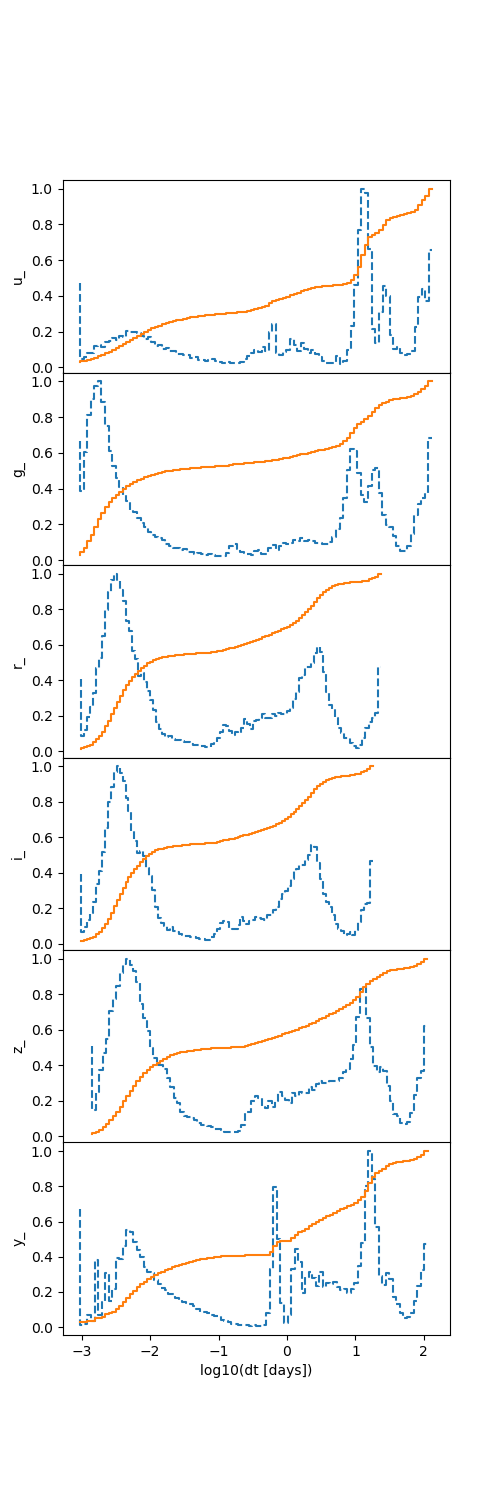

{'u_': 54.35130278526505, 'g_': 73.87451332734352, 'r_': 161.4064091045223, 'i_': 162.23060796645703, 'z_': 147.71069182389937, 'y_': 133.66457023060798}


In [9]:
f,ax = plt.subplots(len(filters),1, figsize=(5,15), sharex=True)

#d = 'primary_output_files/' #primary only take into account the fields with most obs, but using this would overcount total number of available observations
d = 'output_files/' #uses all fields with >0 observations
files = os.listdir(d)
IDs = []
bins = {}
pdf = {}
cdf = {}
Nobs = {}
for i,file in enumerate(files):
    dist = pickle.load( open( d+file, "rb"))
    for f in filters:
        if (i == 0):
            bins[f] = dist[f]['bins']
            pdf[f] = dist[f]['pdf']
            Nobs[f] = dist[f]['Nobs']
        if (i > 0):
            xx = np.where(np.logical_or(np.isinf(dist[f]['pdf']), np.isnan(dist[f]['pdf'])))[0]
            if (len(xx) > 0):
                #print(file, xx, dist[f])
                dist[f]['pdf'][xx] = np.zeros_like(xx)
            pdf[f] += dist[f]['pdf']
            Nobs[f] += dist[f]['Nobs']

outDist = {}
for a,f in zip(ax, filters):
    Nobs[f] /= float(len(files))
    
    cdf[f] = np.cumsum(pdf[f])
    
    pdf[f] /= np.max(pdf[f])
    cdf[f] /= np.max(cdf[f])

    outDist[f] = {}
    outDist[f]['Nobs'] = Nobs[f]
    outDist[f]['bins'] = bins[f]
    outDist[f]['cdf'] = cdf[f]

    a.step(bins[f],pdf[f],linestyle='--')
    a.step(bins[f],cdf[f])
    a.set_ylabel(f)


ax[-1].set_xlabel('log10(dt [days])')
plt.subplots_adjust(hspace=0)

#pickle.dump( outDist, open( "OpSim_primary_dtDist.pickle", "wb" ) )
pickle.dump( outDist, open( "OpSim_observed_dtDist.pickle", "wb" ) )
#print(cdf)
print(Nobs)

*Test drawing observations*

<IPython.core.display.Javascript object>


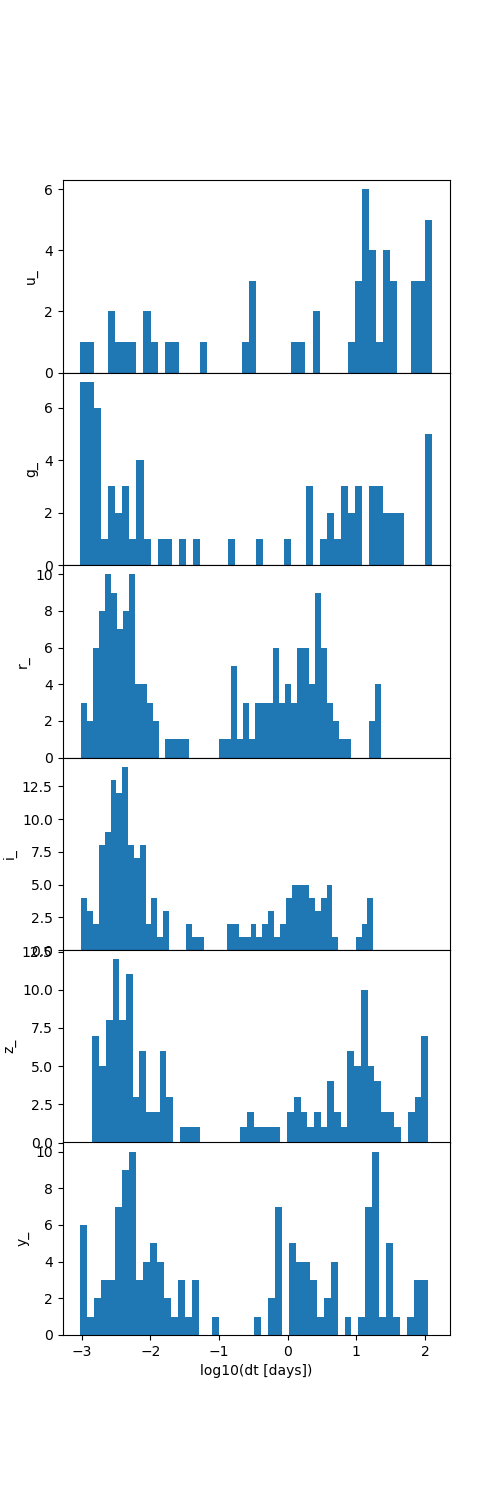

In [66]:

f,ax = plt.subplots(len(filters),1, figsize=(5,15), sharex=True)
for f,a in zip(filters,ax):
    N = round(Nobs[f])
    dt = []
    for i in range(N):
        y = np.random.random()
        dt.append(10.**np.interp(y, cdf[f], bins[f]))
    dates = np.cumsum(np.array(dt))

    _ = a.hist(np.log10(dt), bins=50)
    a.set_ylabel(f)


ax[-1].set_xlabel('log10(dt [days])')
plt.subplots_adjust(hspace=0)